In [20]:
from google.colab import drive #buat loot drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/ml/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [21]:
# Definisikan path untuk data train dan data validation

base_dir = '/tmp/chest_xray'


test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')

test_NORMAL_dir = os.path.join(test_dir, 'NORMAL')
test_PNEUMONIA_dir = os.path.join(test_dir, 'PNEUMONIA')

train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')

In [22]:
import cv2
import numpy as np

# Gather data test
test_data = []
test_label = []
for r, d, f in os.walk(test_dir):
    for file in f:
        if ".jpeg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            test_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            test_label.append(label)

test_data = np.array(test_data)
test_label = np.array(test_label)

In [23]:
# Gather data validation
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpeg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

Data Preprocessing

In [24]:
# Tampilkan shape dari data train dan data validation
print("Test Data = ", test_data.shape)
print("Test Label = ", test_label.shape)
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)

Test Data =  (624, 150, 150, 3)
Test Label =  (624,)
Train Data =  (5232, 150, 150, 3)
Train Label =  (5232,)


In [25]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", test_data[0][0][0])

x_test = test_data.astype('float32') / 255.0
x_train = train_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_test[0][0][0])

Data sebelum di-normalisasi  [0 0 0]
Data setelah di-normalisasi  [0. 0. 0.]


In [26]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", test_label[100:110])

lb = LabelEncoder()
y_test = lb.fit_transform(test_label)
y_train = lb.fit_transform(train_label)

print("Label setelah di-encoder ", y_test[100:110])

Label sebelum di-encoder  ['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL'
 'NORMAL' 'NORMAL']
Label setelah di-encoder  [0 0 0 0 0 0 0 0 0 0]


Definisikan Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten

In [28]:
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())

In [29]:

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
# Print model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 19, 19, 64)      

In [31]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training Model

In [32]:
H = model.fit(x_test, y_test, batch_size=20, epochs=15, validation_data=(x_train, y_train))

Epoch 1/15
32/32 [==============================] - 4s 115ms/step - loss: 0.6048 - acc: 0.6619 - val_loss: 0.5629 - val_acc: 0.7041
Epoch 2/15
32/32 [==============================] - 3s 93ms/step - loss: 0.2839 - acc: 0.8766 - val_loss: 0.2973 - val_acc: 0.8763
Epoch 3/15
32/32 [==============================] - 3s 91ms/step - loss: 0.1905 - acc: 0.9295 - val_loss: 0.3382 - val_acc: 0.8498
Epoch 4/15
32/32 [==============================] - 3s 91ms/step - loss: 0.1952 - acc: 0.9311 - val_loss: 0.3468 - val_acc: 0.8481
Epoch 5/15
32/32 [==============================] - 3s 91ms/step - loss: 0.1315 - acc: 0.9455 - val_loss: 0.5302 - val_acc: 0.8125
Epoch 6/15
32/32 [==============================] - 3s 91ms/step - loss: 0.1002 - acc: 0.9535 - val_loss: 0.4524 - val_acc: 0.8410
Epoch 7/15
32/32 [==============================] - 3s 92ms/step - loss: 0.0697 - acc: 0.9712 - val_loss: 0.7013 - val_acc: 0.7920
Epoch 8/15
32/32 [==============================] - 3s 91ms/step - loss: 0.0735 - 

Evaluasi Model

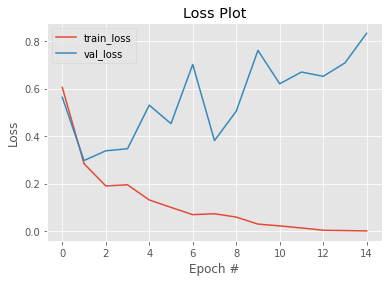

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

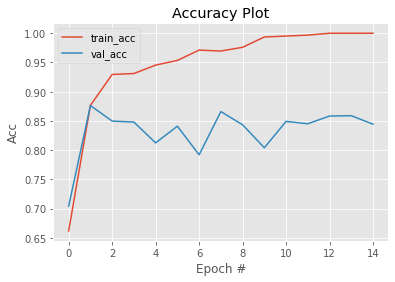

In [34]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import classification_report

pred = model.predict(x_train)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_train, labels))

              precision    recall  f1-score   support

           0       0.64      0.92      0.75      1349
           1       0.97      0.82      0.89      3883

    accuracy                           0.84      5232
   macro avg       0.80      0.87      0.82      5232
weighted avg       0.88      0.84      0.85      5232



In [36]:
from keras.models import save_model
model = save_model(model,'tugas6(1).h5')